<a href="https://colab.research.google.com/github/gh0st-kid/TimeSeries_Analysis_and_Forecasting/blob/main/TS_model_Holt_Winters(q).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import logging

In [ ]:
warnings.filterwarnings('ignore')
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [ ]:
def check_versions():
  print(f'Pandas версия: {pd.__version__}')
  print(f'Numpy версия: {np.__version__}')
  print(f'Matplotlib версия: {plt.matplotlib.__version__}')
  print(f'Seaborn версия: {sns.__version__}')
  print(f'Scikit-learn версия: {sklearn.__version__}')
  print(f'Statsmodels версия: {sm.__version__}')
  print(f'Библиотеки успешно импортированы.')

check_versions()

Pandas версия: 2.2.2
Numpy версия: 1.26.4
Matplotlib версия: 3.7.1
Seaborn версия: 0.13.1
Scikit-learn версия: 1.5.2
Statsmodels версия: 0.14.4
Библиотеки успешно импортированы.


In [ ]:
def load_and_prepare_data(file_path):
  """
  Загружает и подготавливает данные из CSV файла.

  Аргументы:
  file_path : str
      Путь к CSV файлу с данными.

  Возвращает:
  pandas.DataFrame
      Подготовленный датафрейм с данными, где:
    - Удалены пробелы из названий столбцов.
    - Столбец 'year' преобразован в кварталы и удалён.
    - Все числовые столбцы преобразованы в тип float.
    - Данные отсортированы по кварталу.
  """
  df = pd.read_csv(file_path, delimiter=',')
  df.columns = df.columns.str.strip()
  df['year'] = pd.to_datetime(df['year'], format='%m/%d/%Y')
  df['quarter'] = df['year'].dt.to_period('Q')
  numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
  df[numeric_columns] = df[numeric_columns].astype(float)
  df.sort_values('quarter', inplace=True)
  df.drop(columns=['year'], inplace=True)
  df.set_index('quarter', inplace=True)
  df.index = df.index.to_timestamp()
  return df

df = load_and_prepare_data('/content/df.csv')

In [ ]:
df.head(10)

,zan(cfo),zan(szfo),zan(ufo),zan(skfo),zan(pfo),zan(uralfo),zan(sfo),zan(dfo),bezr(cfo),bezr(szfo),...,bezr(sfo),bezr(dfo),srd(cfo),srd(szfo),srd(ufo),srd(skfo),srd(pfo),srd(uralfo),srd(sfo),srd(dfo)
quarter,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19402.5,7169.8,6260.5,3433.2,14150.9,5872.8,8821.8,3049.5,1143.2,524.3,...,1018.8,354.1,20994.4,17568.0,12560.4,10168.8,13275.0,19566.3,12770.6,17202.3
2010-04-01,19675.6,7175.0,6532.1,3714.1,14762.3,5988.3,9167.9,3125.1,944.4,443.9,...,894.2,291.9,25046.3,20140.8,14287.9,12212.4,15659.0,21734.1,14862.1,20543.2
2010-07-01,19895.0,7257.4,6588.1,3703.4,14957.0,6077.4,9461.4,3232.5,900.3,415.4,...,779.5,248.2,23340.4,19058.9,15746.2,13841.7,15731.1,21178.0,14817.9,20412.1
2010-10-01,19892.0,7149.9,6374.2,3703.8,14787.7,6081.8,9110.5,3161.3,855.2,427.5,...,786.9,286.0,29517.9,22802.4,17856.1,17200.4,18629.5,24847.0,17523.5,24927.0
2011-01-01,19722.3,7204.1,6415.3,3670.4,14396.5,6008.9,8923.6,3163.7,943.6,475.3,...,869.3,293.1,22688.4,19065.0,14001.0,11427.8,14494.9,20607.8,14291.7,18913.8
2011-04-01,19974.6,7260.7,6474.7,3832.3,14809.1,6141.6,9166.9,3198.5,836.4,372.5,...,836.5,233.9,27060.0,21536.3,15696.5,13579.3,16737.6,23583.6,16273.5,21702.1
2011-07-01,20342.7,7347.3,6605.1,3901.0,15057.5,6170.0,9315.7,3248.7,828.8,362.3,...,768.8,238.5,25919.8,20866.1,17494.3,15845.5,17440.6,23509.8,16274.1,22692.8
2011-10-01,20188.0,7309.3,6452.0,3762.0,14940.3,6088.5,9127.4,3207.8,821.5,354.6,...,748.3,251.8,32849.0,23565.9,19222.4,19677.1,20433.5,28153.3,19448.0,28099.1
2012-01-01,20106.7,7274.9,6406.9,3732.5,14458.1,6041.3,8898.5,3156.9,784.2,352.1,...,740.8,262.7,24303.0,19997.0,14824.0,12986.0,16201.0,22502.0,15772.0,19449.0


In [ ]:
def split_train_test_by_ratio(df, variable_name, train_size=0.8):
  """
  Простое разбиение временного ряда на обучающую и тестовую выборки.

  Аргументы:
  df : pandas.DataFrame
      Исходный датафрейм, содержащий временной ряд.
  variable_name : str
      Название переменной (столбца) в датафрейме df для анализа.
  train_size : float
      Доля данных, которая пойдёт в обучающую выборку.

  Возвращает:
  train : pandas.Series
      Обучающая выборка.
  test : pandas.Series
      Тестовая выборка.
  """
  #if not isinstance(series, pd.Series):
    #raise TypeError("Ожидался pandas.Series на вход.")

  split_index = int(len(df) * train_size)
  train = df.iloc[:split_index][variable_name]
  test = df.iloc[split_index:][variable_name]
  return train, test

In [ ]:
print("Обычное разбиение:")
train, test = split_train_test_by_ratio(df, 'bezr(cfo)', train_size=0.8)
print((train))

Обычное разбиение:
quarter
2010-01-01    1143.2
2010-04-01     944.4
2010-07-01     900.3
2010-10-01     855.2
2011-01-01     943.6
2011-04-01     836.4
2011-07-01     828.8
2011-10-01     821.5
2012-01-01     784.2
2012-04-01     641.5
2012-07-01     613.0
2012-10-01     596.9
2013-01-01     718.4
2013-04-01     667.5
2013-07-01     689.5
2013-10-01     715.8
2014-01-01     680.6
2014-04-01     652.9
2014-07-01     640.4
2014-10-01     646.3
2015-01-01     734.4
2015-04-01     763.5
2015-07-01     731.1
2015-10-01     750.4
2016-01-01     805.9
2016-04-01     774.0
2016-07-01     726.7
2016-10-01     713.3
2017-01-01     752.5
2017-04-01     688.2
2017-07-01     658.6
2017-10-01     665.2
2018-01-01     660.2
2018-04-01     618.3
2018-07-01     589.3
2018-10-01     611.9
2019-01-01     626.2
2019-04-01     602.8
Freq: QS-OCT, Name: bezr(cfo), dtype: float64


In [ ]:
def find_optimal_holt_winters_params(df, variable_name, seasonal_periods = 4):
  """
  Находит оптимальные параметры для модели Хольта-Винтерса (Holt-Winters) с
  использованием метода наименьших квадратов (MSE).

  Аргументы:
      df : pandas.DataFrame
          Исодный датафрейм, содержащий временные ряды.
      variable_name : str
          Название переменной (столбца) в датафрейме df для анализа.
      seasonal_periods : int, optional
          Количество периодов сезонности. Для квартальных данных по умолчанию 4.

  Возвращает:
      tuple
          Кортеж, содержащий оптимальные параметры smoothing_level,
          smoothing_slope и smoothing_seasonal.
  """
  #Задаем диапазон значений для параметров
  smoothing_level_range = np.arange(0.1, 0.91, 0.1)
  smoothing_slope_range = np.arange(0.1, 0.91, 0.1)
  smoothing_seasonal_range = np.arange(0.1, 0.91, 0.1)

  #Инициализация минимальной ошибки
  min_rmse = np.inf

  for smoothing_level in smoothing_level_range:
    for smoothing_slope in smoothing_slope_range:
      for smoothing_seasonal in smoothing_seasonal_range:
        try:
          #Подгонка модели с текущими параметрами
          model_hw = ExponentialSmoothing(df[variable_name], trend = 'add',
                                          seasonal = 'mul',
                                          seasonal_periods = seasonal_periods)
          fitted_model = model_hw.fit(smoothing_level = smoothing_level,
                                      smoothing_slope = smoothing_slope,
                                      smoothing_seasonal = smoothing_seasonal)

          #Прогнозирование на основе обученной модели
          fitted_values = fitted_model.fittedvalues

          #Расчёт ошибки RMSE
          rmse = np.sqrt(mean_squared_error(df[variable_name], fitted_values))

          #Обновление минимальной ошибки и оптимальных параметров
          if rmse < min_rmse:
            min_rmse = rmse
            optimal_smoothing_level = smoothing_level
            optimal_smoothing_slope = smoothing_slope
            optimal_smoothing_seasonal = smoothing_seasonal
        except Exception as e:
          #Игнорируем ошибки, возникающие при плохих параметрах
          continue

  #Вывод оптимальных параметров и минимальной RMSE
  print(f'Оптимальные параметры smooting_level: {optimal_smoothing_level}')
  print(f'Оптимальные параметры smoothing_slope: {optimal_smoothing_slope}')
  print(f'Оптимальные параметры smoothing_seasonal: {optimal_smoothing_seasonal}')
  print(f'Минимальная RMSE: {min_rmse}')

  return (optimal_smoothing_level, optimal_smoothing_slope,
          optimal_smoothing_seasonal)

In [ ]:
find_optimal_holt_winters_params(df, 'bezr(cfo)')

Оптимальные параметры smooting_level: 0.9
Оптимальные параметры smoothing_slope: 0.1
Оптимальные параметры smoothing_seasonal: 0.1
Минимальная RMSE: 64.68501837144443


(0.9, 0.1, 0.1)

In [ ]:
find_optimal_holt_winters_params(df, 'srd(cfo)')

Оптимальные параметры smooting_level: 0.7000000000000001
Оптимальные параметры smoothing_slope: 0.1
Оптимальные параметры smoothing_seasonal: 0.5
Минимальная RMSE: 1548.6236766483817


(0.7000000000000001, 0.1, 0.5)

In [ ]:
def train_holt_winters(train, seasonal_periods = 4, trend='add', seasonal='mul',
                       smoothing_level=0.7, smoothing_slope=0.9,
                       smoothing_seasonal=0.9):
  """
  Обучает модель Хольта-Винтерса (Holt-Winters) на обучающей выборке.

  Аргументы:
      train : pandas.Series
          Обучающая выборка временного ряда с квартальной частотой.
      seasonal_periods : int, optional
          Количество периодов для сезонности. Для квартальных данных по
          умолчанию 4.
      trend : str, optional
          Тип тренда. По умолчанию 'add' (аддитивный тренд).
      seasonal : str, optional
          Тип сезонности. По умолчанию 'mul' (мультипликативная сезонность).
      smoothing_level : float, optional
          Уровень сглаживания. По умолчанию 0.7.
      smoothing_slope : float, optional
          Сглаживание тренда. По умолчанию 0.9.
      smoothing_seasonal : float, optional
          Сглаживание сезонности. По умолчанию 0.9.

  Возвращает:
      HoltWintersResults
          Обученная модель Хольта-Винтерса (Holt-Winters).
  """
  model = ExponentialSmoothing(train, trend = trend, seasonal = seasonal,
                               seasonal_periods = seasonal_periods)
  model_fit = model.fit(smoothing_level = smoothing_level,
                        smoothing_slope = smoothing_slope,
                        smoothing_seasonal = smoothing_seasonal)
  return model_fit

In [ ]:
train_holt_winters(train, seasonal_periods = 4,
                       smoothing_level=0.9, smoothing_slope=0.1,
                       smoothing_seasonal=0.1)

In [ ]:
def forecast_holt_winters(train, test, seasonal_periods = 4,
                          smoothing_level = 0.7, smoothing_slope = 0.9,
                          smoothing_seasonal = 0.8, future_periods = 3):
  """
  Прогнозирует значения временного ряда с использованием модели Хольта-Винтерса
  (Holt-Winters) для квартальных данных.

  Аргументы:
      train : pandas.Series
          Обучающая выборка временного ряда.
      test : pandas.Series
          Тестовая выборка временного ряда.
      seasonal_periods : int, optional
          Период сезонности. Для квартальных данных по умолчанию 4.
      smoothing_level : float, optional
          Уровень сглаживания. По умолчанию 0.7.
      smoothing_slope : float, optional
          Сглаживание тренда. По умолчанию 0.9.
      smoothing_seasonal : float, optional
          Сглаживание сезонности. По умолчанию 0.8.
      future_periods : int, optional
          Количество периодов для прогнозирования после тестового периода.
          По умолчанию 3.

  Возвращает:
      tuple
          Кортеж, содержащий прогноз на тестовом периоде (forecast) и прогноз
          на будущие периоды (future_forecast).
  """
  #Прогноз на тестовый период
  model_hw = ExponentialSmoothing(train, trend = 'add', seasonal = 'mul',
                                  seasonal_periods = seasonal_periods).fit(
                                      smoothing_level = smoothing_level,
                                      smoothing_slope = smoothing_slope,
                                      smoothing_seasonal = smoothing_seasonal
                                  )
  forecast = model_hw.forecast(steps = len(test))

  #Создание модели на основе данных train + test
  combined_series = pd.concat([train, test])
  full_model_hw = ExponentialSmoothing(
      combined_series, trend = 'add', seasonal = 'mul',
      seasonal_periods = seasonal_periods).fit(
          smoothing_level = smoothing_level,
          smoothing_slope = smoothing_slope,
          smoothing_seasonal = smoothing_seasonal
      )

  #Прогноз на будущие периоды начиная с конца тестового периода
  future_forecast = full_model_hw.forecast(steps=future_periods)

  return forecast, future_forecast

In [ ]:
forecast, future_forecast = forecast_holt_winters(train, test, seasonal_periods = 4,
                          smoothing_level = 0.9, smoothing_slope = 0.1,
                          smoothing_seasonal = 0.1, future_periods = 3)

In [ ]:
def evaluate_forecast(test, forecast):
  """
  Оценивает точность прогноза с использованием метрик RMSE, MAE, MAPE.\

  Аргументы:
      test : pandas.Series
          Реальные значения из тестовой выборки.
      forecast : pandas.Series
          Прогнозируемые значения.

  Возвращает:
      tuple
          Кортеж, содержащий RMSE, MAE и MAPR (соответственно).
  """
  rmse = np.sqrt(mean_squared_error(test, forecast))
  mae = mean_absolute_error(test, forecast)
  mape = mean_absolute_percentage_error(test, forecast)*100
  return rmse, mae, mape

In [ ]:
evaluate_forecast(test, forecast)

(237.19511721040897, 194.34846504160677, 23.683622147170375)

In [ ]:
def plot_holt_winters(df, train, test, forecast, future_forecast,
                      variable_name):
  """
  Визуализирует временной ряд, обучающую выборку, прогноз на тестовом периоде и
  прогнози на будущие периоды для модели Хольта-Винтерса (Holt-Winters).

  Аргументы:
      df : pandas.DataFrame
          Исходный датафрейм, содержащий временной ряд.
      train : pandas.Series
          Обучающая выборка.
      test : pandas.Series
          Тестовая выборка.
      forecast : pandas.Series
          Прогноз на тестовом периоде.
      future_forecast : pandas.Series
          Прогноз на будущие периоды.
      variable_name : str
          Название временного ряда.
  """
  plt.figure(figsize = (12,6))

  #Исходный временной ряд
  plt.plot(df.index, df[variable_name], label = 'Исходный ряд', color = 'blue')

  #Обучающая выборка
  plt.plot(train.index, train, label = 'Обучающая выборка', color = 'green')

  #Прогноз на тестовом периоде
  plt.plot(test.index, forecast, label = 'Прогноз на тестовом периоде',
           color = 'orange')

  #Создание индекса для прогноза на будущее (с квартальной частотой)
  future_forecast_index = pd.date_range(start = test.index[-1] + test.index.freq,
                                       periods = len(future_forecast),
                                       freq = 'Q')
  #Прогноз на будущее
  plt.plot(future_forecast_index, future_forecast, label = 'Прогноз на будущее',
           linestyle = '--', marker = 'o', color = 'red')

  #Настройка графика
  plt.title('Прогноз с использованием модели Хольта-Винтерса')
  plt.xlabel('Дата')
  plt.ylabel('Значение')
  plt.legend()
  plt.grid(True)
  plt.show()

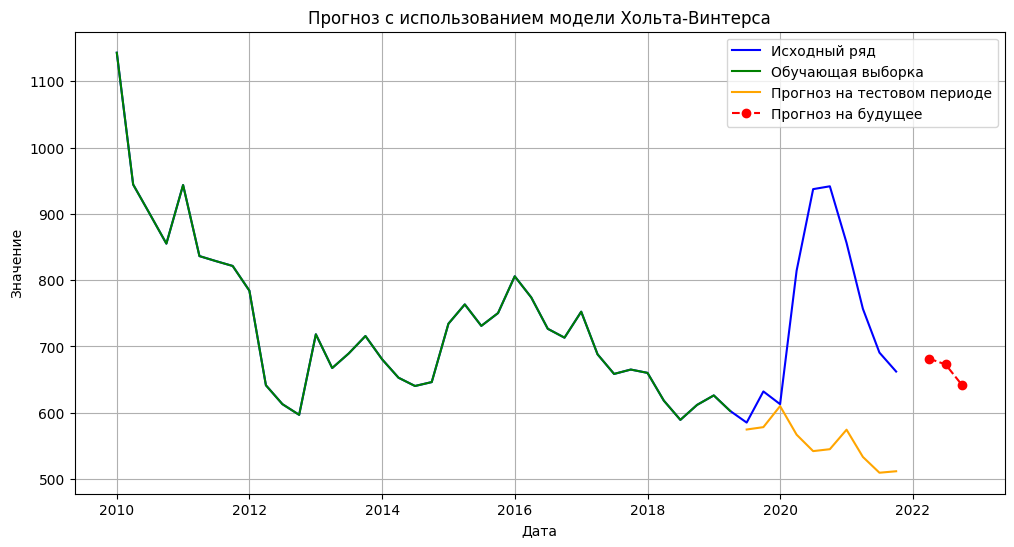

In [ ]:
plot_holt_winters(df, train, test, forecast, future_forecast, 'bezr(cfo)')

In [ ]:
def holt_winters_pipeline(df, variable_name, smoothing_level = 0.7,
                          smoothing_slope = 0.9, smoothing_seasonal = 0.8,
                          seasonal_periods = 4, train_size = 0.7,
                          future_periods = 3):
  """
  Пайплайн для выполнения анализа модели с использованием модели
  Хольта-Винтерса, включая разделение данных, обучение модели, прогнозирование,
  оценку прогноза и визуализацию результатов.

  Аргументы:
      df : pandasDataFrame
          Исходный датафрейм, содержащий временной ряд.
      variable_name : str
          Название переменной (столбца) в датафрейме df для анализа.
      smoothing_level : float, optional
          Уровень сглаживания. По умолчания 0.7.
      smoothing_slope : float, optional
          Сглаживание тренда. По умолчанию 0.9.
      smoothing_seasonal : float, optional
          Сглаживание сезонности. По умолчанию 0.8.
      seasonal_periods : int, optional
          Длина сезонного периода (для квартальных данных по умолчанию 4).
      train_size : float, optional
          Доля обучающей выборки (по умолчанию 0.7).
      future_periods : int, optional
          Количество периодов для прогнозирования после тестового периода
          (по умолчанию 3).

  Возвращает:
      tuple
          Кортеж, содержащий метрики оценки модели (RMSE, MAE, MAPE) и прогноз
          на будущие периоды.
  """
  #1.Разделение данных
  train, test = split_train_test_by_ratio(df, variable_name, train_size)

  #2.Прогнозирование
  forecast, future_forecast = forecast_holt_winters(
      train, test, seasonal_periods=seasonal_periods,
      smoothing_level=smoothing_level, smoothing_slope=smoothing_slope,
      smoothing_seasonal=smoothing_seasonal, future_periods=future_periods)

  #3.Оценка прогноза
  rmse, mae, mape = evaluate_forecast(test, forecast)
  metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

  #4.Визуализация
  plot_holt_winters(df, train, test, forecast, future_forecast, variable_name)

  return metrics, future_forecast

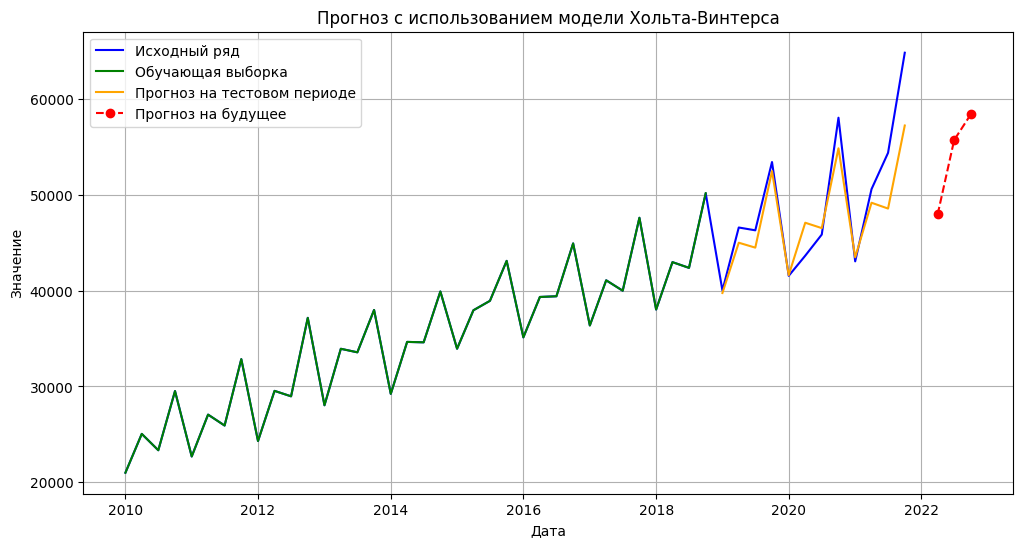

({'RMSE': 3201.7024322197076,
  'MAE': 2270.475642296428,
  'MAPE': 4.2485452092889},
 2022-01-01    47953.096751
 2022-04-01    55716.909751
 2022-07-01    58410.507808
 Freq: QS-OCT, dtype: float64)

In [ ]:
holt_winters_pipeline(df, 'srd(cfo)', smoothing_level=0.7,
                      smoothing_slope=0.1, smoothing_seasonal=0.5,
                      train_size = 0.75)

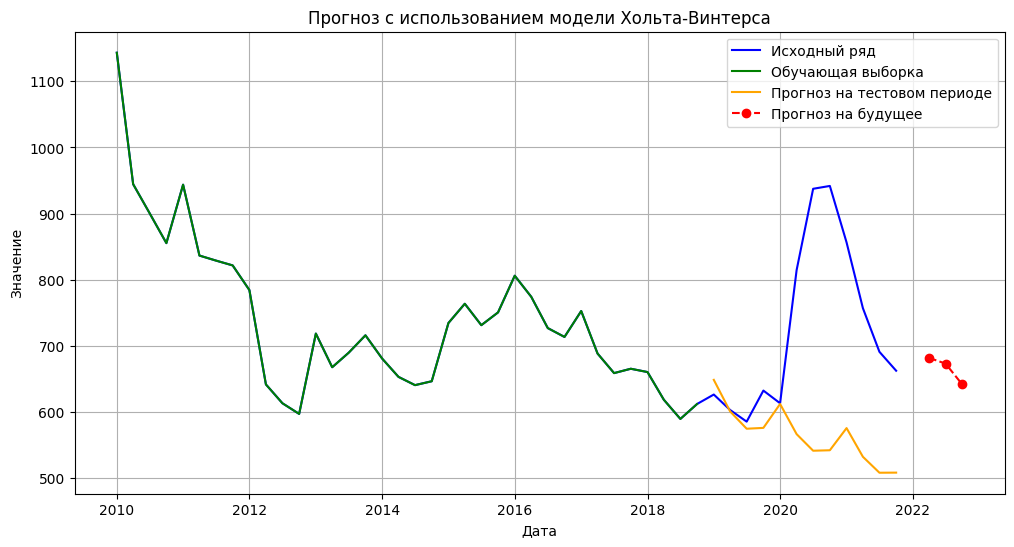

({'RMSE': 217.7069990230201,
  'MAE': 164.94773022740424,
  'MAPE': 20.189920945496244},
 2022-01-01    681.679580
 2022-04-01    672.987901
 2022-07-01    641.394804
 Freq: QS-OCT, dtype: float64)

In [ ]:
holt_winters_pipeline(df, 'bezr(cfo)', smoothing_level=0.9,
                      smoothing_slope=0.1, smoothing_seasonal=0.1,
                      train_size = 0.75)